In [68]:
# Physical parameters
rabi_frequency = 2.5 * 1e3  # Hz 2pi
trapping_frequency = 120 * 1e3  # Trapping frequency Hz 2pi
correction = 1.46
# Parameter eta: Lamb-Dicke parameter
eta = None
# Anharmonicity trap
anharmonicity = 500 # Hz
# Probability to be in the ground state for the motional state
p0 = 0.84  # 84
# -------------------
# Numerical parameters
fock_space_dimension = 6  # number of transverse modes
resolution = 5e5
# -------------------
# Simulation
equation = "lindblad"

In [69]:
import numpy as np
import tensorflow as tf

# Mute warning messages
tf.get_logger().setLevel("FATAL")

# Model for single qubit gate in 1D

Main simulation parameters are defined in the first cell and massaged in the following one.

In [70]:
# Physical parameters
from qruise.toolset.libraries.rydberg.utils import get_lamb_dicke_parameter
from qruise.toolset.libraries.rydberg.utils import get_anharmonicity_z

eta = (
    eta if eta is not None else get_lamb_dicke_parameter(2 * np.pi * trapping_frequency)
)
# Anharmonicity trap
anharmonicity = anharmonicity if anharmonicity is not None else get_anharmonicity_z()

## Model definition

In [71]:
from qruise.toolset.libraries.rydberg import ModelBuilder
from qruise.toolset.libraries.rydberg.subsystems import motional_state, spin
from qruise.toolset.libraries.rydberg.drives import rydberg_motional_drive

# Create the model builder
model_builder = ModelBuilder()

# Add motional state
motional_st = model_builder.add_subsystem(
    motional_state,
    name="motional_state",
    fock_space_dimension=fock_space_dimension,
    frequency=trapping_frequency,
    anharmonicity=anharmonicity,
    p0=p0,
)
# Add spin
spin_st = model_builder.add_subsystem(spin, name="spin", t1=270e-3, t2star=100e-3)
# Create the drive
drive_xy_0 = model_builder.add_drive(
    rydberg_motional_drive,
    name="drive_xy_0",
    motional_state=motional_st,
    spin=spin_st,
    omega=rabi_frequency,
    eta=eta,
    correction=correction,
    relative_intensity_error=0.0,
)

drive_xy_1 = model_builder.add_drive(
    rydberg_motional_drive,
    name="drive_xy_1",
    motional_state=motional_st,
    spin=spin_st,
    omega=rabi_frequency,
    eta=eta,
    correction=correction,
    relative_intensity_error=0.005,
)

drive_xy_2 = model_builder.add_drive(
    rydberg_motional_drive,
    name="drive_xy_2",
    motional_state=motional_st,
    spin=spin_st,
    omega=rabi_frequency,
    eta=eta,
    correction=correction,
    relative_intensity_error=-0.005,
)


# Get the model and the generator
model = model_builder.get_model(equation=equation)
generator = model_builder.get_signal_generator()

In [72]:
theta = np.pi

Define the envelopes for the pulses

In [73]:
from qruise.toolset.builders.sequence_builder import SequenceBuilder
from qruise.toolset.libraries.rydberg.instructions import r_gate
from qruise.toolset.libraries.rydberg.envelopes import rect_envelope
from qruise.toolset.objects import Quantity

seq_builder = SequenceBuilder()
t_pi = np.pi / (2 * np.pi * rabi_frequency)

In [74]:
t_pi_2 = (np.pi / 2) / (2 * np.pi * rabi_frequency)
R90xp_list = [
    seq_builder.add_gate(
        r_gate,
        name="rx90p" + str(index),
        drive=drive_xy,
        duration=t_pi_2,
        phase_envelope=rect_envelope(name="null_pi", amp=0.0, t_final=t_pi_2),
        omega_envelope=rect_envelope(name="square_pi", amp=1.0, t_final=t_pi_2),
        targets=[0]
    )
    for index, drive_xy in enumerate([drive_xy_0, drive_xy_1, drive_xy_2])
]

R90xm_list = [
    seq_builder.add_gate(
        r_gate,
        name="rx90m" + str(index),
        drive=drive_xy,
        duration=t_pi_2,
        phase_envelope=rect_envelope(name="null_pi", amp=np.pi, t_final=t_pi_2),
        omega_envelope=rect_envelope(name="square_pi", amp=1.0, t_final=t_pi),
        targets=[0]
    )
    for index, drive_xy in enumerate([drive_xy_0, drive_xy_1, drive_xy_2])
]

R90yp_list = [
    seq_builder.add_gate(
        r_gate,
        name="ry90p" + str(index),
        drive=drive_xy,
        duration=t_pi_2,
        phase_envelope=rect_envelope(name="null_pi", amp=np.pi / 2, t_final=t_pi_2),
        omega_envelope=rect_envelope(name="square_pi", amp=1.0, t_final=t_pi_2),
        targets=[0]
    )
    for index, drive_xy in enumerate([drive_xy_0, drive_xy_1, drive_xy_2])
]

R90ym_list = [
    seq_builder.add_gate(
        r_gate,
        name="ry90m" + str(index),
        drive=drive_xy,
        duration=t_pi_2,
        phase_envelope=rect_envelope(name="null_pi", amp=-np.pi / 2, t_final=t_pi_2),
        omega_envelope=rect_envelope(name="square_pi", amp=1.0, t_final=t_pi_2),
        targets=[0]
    )
    for index, drive_xy in enumerate([drive_xy_0, drive_xy_1, drive_xy_2])
]

In [75]:
seq_builder.sequence

[Instruction(rx90p0[0]),
 Instruction(rx90p1[0]),
 Instruction(rx90p2[0]),
 Instruction(rx90m0[0]),
 Instruction(rx90m1[0]),
 Instruction(rx90m2[0]),
 Instruction(ry90p0[0]),
 Instruction(ry90p1[0]),
 Instruction(ry90p2[0]),
 Instruction(ry90m0[0]),
 Instruction(ry90m1[0]),
 Instruction(ry90m2[0])]

Create the parameter map and the experiment

In [76]:
from qruise.toolset.parametermap import ParameterMap

parameter_map = ParameterMap(
    instructions=seq_builder.sequence, model=model, generator=generator
)
gateset_opt_map = []
parameter_map.set_opt_map(gateset_opt_map)

In [77]:
from qruise.toolset.experiment import Experiment

simulation = Experiment(pmap=parameter_map, sim_res=resolution)

Draw the dynamics

In [78]:
initial_state = model.adjust_init_state(model.get_thermal_state())

In [79]:
propagators = simulation.compute_propagators()

In [80]:
propagators

{'rx90m2[0]': TensorPropagator(Instruction(rx90m2[0])),
 'ry90p0[0]': TensorPropagator(Instruction(ry90p0[0])),
 'ry90p1[0]': TensorPropagator(Instruction(ry90p1[0])),
 'rx90p1[0]': TensorPropagator(Instruction(rx90p1[0])),
 'rx90p0[0]': TensorPropagator(Instruction(rx90p0[0])),
 'ry90m2[0]': TensorPropagator(Instruction(ry90m2[0])),
 'ry90p2[0]': TensorPropagator(Instruction(ry90p2[0])),
 'ry90m1[0]': TensorPropagator(Instruction(ry90m1[0])),
 'rx90m0[0]': TensorPropagator(Instruction(rx90m0[0])),
 'rx90p2[0]': TensorPropagator(Instruction(rx90p2[0])),
 'rx90m1[0]': TensorPropagator(Instruction(rx90m1[0])),
 'ry90m0[0]': TensorPropagator(Instruction(ry90m0[0]))}

In [81]:
trace_func_atom = simulation.ptrace_transform(spin_st.name)
trace_func_motional_state = simulation.ptrace_transform(motional_st.name)

In [82]:
seq_builder.sequence

[Instruction(rx90p0[0]),
 Instruction(rx90p1[0]),
 Instruction(rx90p2[0]),
 Instruction(rx90m0[0]),
 Instruction(rx90m1[0]),
 Instruction(rx90m2[0]),
 Instruction(ry90p0[0]),
 Instruction(ry90p1[0]),
 Instruction(ry90p2[0]),
 Instruction(ry90m0[0]),
 Instruction(ry90m1[0]),
 Instruction(ry90m2[0])]

## RB sequence

In [83]:
from qruise.toolset.qiskit import QruiseProvider
from qiskit import QuantumCircuit

In [84]:
qruise_provider = QruiseProvider()
qruise_backend = qruise_provider.get_backend("qruise_qasm_rydberg_simulator")
qruise_backend._qubit_trace_func = trace_func_atom
qiskit_exp = simulation

In [85]:
qruise_backend._initial_state_vector = initial_state

In [86]:
qruise_backend.set_qruise_experiment(qiskit_exp)

In [87]:
def state_transform_function(drive_index: int) -> callable:
    def state_transform(
        state: tf.Tensor, gate_dict: dict, reshape_after: bool, reshape_before: bool
    ):
        state = qiskit_exp.lookup_propagator(
            **gate_dict,
            compute=True,
            gate_index=f"{str(drive_index)}",
        ).propagate_state(
            state, reshape_after=reshape_after, reshape_before=reshape_before
        )
        return state

    return state_transform

In [88]:
def lookup_transform_function(drive_index: int) -> callable:
    def lookup_transform(gate_dict: dict):
        gate_name = gate_dict["name"] + str(drive_index)
        return {
            gate_name: qiskit_exp.lookup_propagator(
                **gate_dict, compute=False, gate_index=f"{str(drive_index)}"
            )
        }, [gate_name]

    return lookup_transform

In [89]:
length = 8
num_samples = 4


seed = 1010
qubits = [0]

from qruise.toolset.utils import qt_utils

seqs = qt_utils.single_length_RB(RB_number=num_samples, RB_length=length, target=0)

In [90]:
from qruise.toolset.qiskit.gates import RX90pGate, RX90mGate, RY90pGate, RY90mGate
from qiskit.circuit import Measure

QISKIT_GATE_MAP = {
    "rx90p": RX90pGate,
    "rx90m": RX90mGate,
    "ry90p": RY90pGate,
    "ry90m": RY90mGate,
    "measure": Measure,
}


def seqs_to_circuit(
    seqs: list[list[str]], n_qubits: int = 1
) -> list[list[QuantumCircuit]]:
    circuits = []
    for seq in seqs:
        qc_sec = QuantumCircuit(
            n_qubits, n_qubits
        )  # will usually be measured so n_cbits=n_qubits
        for gate in seq:
            qiskit_gate = QISKIT_GATE_MAP[gate[:-3]]
            if qiskit_gate != Measure:
                qc_sec.append(qiskit_gate(), [int(gate[-2])])
            else:
                qc_sec.append(qiskit_gate(), [int(gate[-2])], [int(gate[-2])])
        circuits.append(qc_sec)
    return circuits

In [91]:
circuits = seqs_to_circuit(seqs)

In [94]:
lengths = np.arange(2, 100, 10, dtype=int)
num_samples = 40

pop_0 = []
entanglement = []
# Loop over different lengths
for length in lengths:
    # Generate the sequences
    seqs = qt_utils.single_length_RB(RB_number=num_samples, RB_length=length, target=0)
    # Convert the sequences to circuits
    circuits = seqs_to_circuit(seqs)
    pop_0_drive = []
    ent_drive = []
    for drive_index in range(3):
        # Populations of the ground state
        qruise_backend._experiment_mode = "populations"
        qruise_backend._state_propagation_function = state_transform_function(
            drive_index
        )
        # Run the circuits
        qruise_job = qruise_backend.run(circuits, shots=1000)
        # Get the counts
        counts = [
            list(result.data.counts.values()) for result in qruise_job.result().results
        ]
        # Get the state populations
        state_pops = [result.data.state_pops for result in qruise_job.result().results]
        # Get the population of the ground state
        pop_0_drive.append([state_pop["(0, 0)"] for state_pop in state_pops])

    # Mean over the drives for entanglement
    ent = np.mean(np.array(ent_drive), axis=0)
    entanglement.append(ent)
    # Mean over the drives for populations
    state_pops = np.mean(np.array(pop_0_drive), axis=0)
    pop_0.append(state_pops)
    # Print the results
    print(f"Length: {length}, Counts: {counts}")

Length: 2, Counts: [[993, 7], [992, 8], [993, 7], [991, 9], [989, 11], [998, 2], [998, 2], [992, 8], [988, 12], [994, 6], [994, 6], [986, 14], [985, 15], [988, 12], [986, 14], [988, 12], [991, 9], [991, 9], [993, 7], [993, 7], [992, 8], [996, 4], [986, 14], [997, 3], [994, 6], [992, 8], [997, 3], [992, 8], [998, 2], [986, 14], [992, 8], [992, 8], [995, 5], [985, 15], [993, 7], [989, 11], [986, 14], [999, 1], [992, 8], [996, 4]]
Length: 12, Counts: [[950, 50], [956, 44], [952, 48], [942, 58], [955, 45], [946, 54], [969, 31], [953, 47], [952, 48], [954, 46], [967, 33], [940, 60], [931, 69], [963, 37], [963, 37], [944, 56], [956, 44], [950, 50], [958, 42], [963, 37], [964, 36], [936, 64], [962, 38], [946, 54], [961, 39], [962, 38], [954, 46], [966, 34], [946, 54], [942, 58], [950, 50], [964, 36], [969, 31], [965, 35], [956, 44], [933, 67], [958, 42], [949, 51], [964, 36], [932, 68]]
Length: 22, Counts: [[893, 107], [919, 81], [892, 108], [923, 77], [920, 80], [906, 94], [917, 83], [932, 6

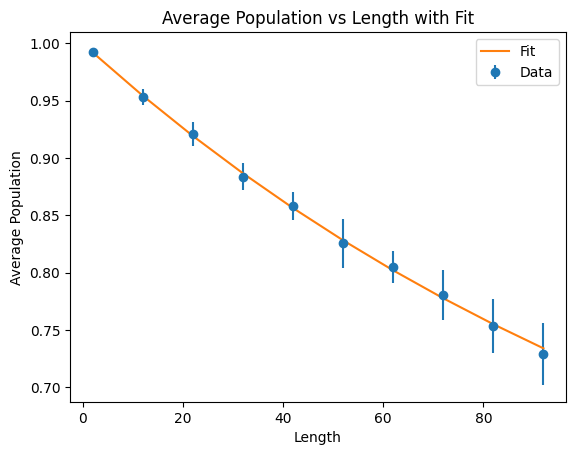

Error per Clifford: 0.00182 ± 0.00018


In [93]:
from qruise.toolset.qiskit.rb_analysis import StandardRBAnalysis
results_square = StandardRBAnalysis(
    lengths=lengths, pops=pop_0
)